In [ ]:
!unzip image_and_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: image_and_mask/Mask/000000047940.png  
  inflating: image_and_mask/Mask/000000232383.png  
  inflating: image_and_mask/Mask/000000457754.png  
  inflating: image_and_mask/Mask/000000056865.png  
  inflating: image_and_mask/Mask/000000268927.png  
  inflating: image_and_mask/Mask/000000414679.png  
  inflating: image_and_mask/Mask/000000028377.png  
  inflating: image_and_mask/Mask/000000127050.png  
  inflating: image_and_mask/Mask/000000503311.png  
  inflating: image_and_mask/Mask/000000161011.png  
  inflating: image_and_mask/Mask/000000170849.png  
  inflating: image_and_mask/Mask/000000520251.png  
  inflating: image_and_mask/Mask/000000239229.png  
  inflating: image_and_mask/Mask/000000144534.png  
  inflating: image_and_mask/Mask/000000560675.png  
  inflating: image_and_mask/Mask/000000009420.png  
  inflating: image_and_mask/Mask/000000139291.png  
  inflating: image_and_mask/Mask/000000407822.png  
  inflating: 

In [ ]:
img_dir = "/content/image_and_mask/Image"
mask_dir  = "/content/image_and_mask/Mask"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride = 2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [ ]:
class Image_Dataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path

        if test:
            self.images = sorted([
                os.path.join(root_path, "test_images", i)
                for i in os.listdir(os.path.join(root_path, "test_images"))
            ])
            self.masks = sorted([
                os.path.join(root_path, "test_masks", i)
                for i in os.listdir(os.path.join(root_path, "test_masks"))
            ])
        else:
            self.images = sorted([
                os.path.join(root_path, "Image", i)
                for i in os.listdir(os.path.join(root_path, "Image"))
            ])
            self.masks = sorted([
                os.path.join(root_path, "Mask", i)
                for i in os.listdir(os.path.join(root_path, "Mask"))
            ])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")  # grayscale for mask
        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)


Using device: cuda
Checking mask values...
Mask check complete. Bad masks: 0


Training: 100%|██████████| 500/500 [14:07<00:00,  1.70s/it]
                                                           
Validation: 100%|██████████| 125/125 [01:32<00:00,  1.37it/s]
                                                             

--------------------------------------------------
Epoch 1/6
Train Loss: 0.5864
Val Loss: 0.5652
--------------------------------------------------


Training: 100%|██████████| 500/500 [14:09<00:00,  1.70s/it]
                                                           
Validation: 100%|██████████| 125/125 [01:33<00:00,  1.34it/s]
                                                             

--------------------------------------------------
Epoch 2/6
Train Loss: 0.5496
Val Loss: 0.5590
--------------------------------------------------


Training: 100%|██████████| 500/500 [14:07<00:00,  1.70s/it]
                                                           
Validation: 100%|██████████| 125/125 [01:33<00:00,  1.36it/s]
                                                             

--------------------------------------------------
Epoch 3/6
Train Loss: 0.5411
Val Loss: 0.5308
--------------------------------------------------


Training: 100%|██████████| 500/500 [14:07<00:00,  1.69s/it]
                                                           
Validation: 100%|██████████| 125/125 [01:33<00:00,  1.36it/s]
                                                             

--------------------------------------------------
Epoch 4/6
Train Loss: 0.5361
Val Loss: 0.5213
--------------------------------------------------


Training: 100%|██████████| 500/500 [14:06<00:00,  1.70s/it]
                                                           
Validation: 100%|██████████| 125/125 [01:33<00:00,  1.37it/s]
                                                             

--------------------------------------------------
Epoch 5/6
Train Loss: 0.5302
Val Loss: 0.5071
--------------------------------------------------


Training: 100%|██████████| 500/500 [14:08<00:00,  1.69s/it]
                                                           
Validation: 100%|██████████| 125/125 [01:33<00:00,  1.33it/s]
                                                             

--------------------------------------------------
Epoch 6/6
Train Loss: 0.5114
Val Loss: 0.5069
--------------------------------------------------


Epochs: 100%|██████████| 6/6 [1:34:08<00:00, 941.40s/it]


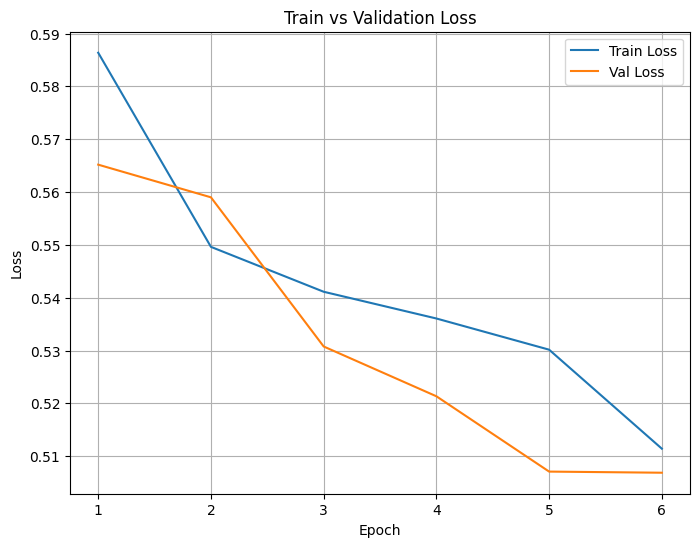

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------
# Main Training Script
# -----------------------
if __name__ == "__main__":
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 8
    EPOCHS = 6
    DATA_PATH = "/content/image_and_mask"
    MODEL_SAVE_PATH = "/content/best_model.pth"

    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load dataset
    full_dataset = Image_Dataset(DATA_PATH)
    dataset_length = len(full_dataset)
    if dataset_length == 0:
        raise ValueError("Dataset is empty. Check paths and files.")

    # Mask value sanity check
    print("Checking mask values...")
    bad_masks = 0
    for i in range(min(20, len(full_dataset))):  # check first 20 masks
        _, mask = full_dataset[i]
        if mask.max() > 1 or mask.min() < 0:
            bad_masks += 1
    print(f"Mask check complete. Bad masks: {bad_masks}")

    # Train/Val split
    generator = torch.Generator().manual_seed(42)
    train_size = int(0.8 * dataset_length)
    val_size = dataset_length - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, loss
    model = UNet(in_channels=3, num_classes=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # Store loss history for plotting
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs"):
        model.train()
        train_loss_sum = 0.0
        for batch_idx, (imgs, masks) in enumerate(tqdm(train_loader, leave=False, desc="Training")):
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)

            # Safety check for NaNs
            if torch.isnan(preds).any() or torch.isnan(masks).any():
                print(f"NaN detected in batch {batch_idx}")
                continue

            loss = criterion(preds, masks)
            train_loss_sum += loss.item()
            loss.backward()
            optimizer.step()
        train_loss = train_loss_sum / (batch_idx + 1)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch_idx, (imgs, masks) in enumerate(tqdm(val_loader, leave=False, desc="Validation")):
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                val_loss_sum += loss.item()
        val_loss = val_loss_sum / (batch_idx + 1)
        val_losses.append(val_loss)

        print("-" * 50)
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print("-" * 50)

        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    # Plot loss graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")

Mounted at /content/drive


In [ ]:
import torch
import matplotlib.pyplot as plt

# -----------------------
# Metrics
# -----------------------
def iou_score(pred_mask, true_mask, eps=1e-6):
    intersection = torch.logical_and(pred_mask, true_mask).sum().float()
    union = torch.logical_or(pred_mask, true_mask).sum().float()
    return (intersection + eps) / (union + eps)

def dice_score(pred_mask, true_mask, eps=1e-6):
    intersection = (pred_mask * true_mask).sum().float()
    return (2. * intersection + eps) / (pred_mask.sum() + true_mask.sum() + eps)

def accuracy_score(pred_mask, true_mask):
    correct = (pred_mask == true_mask).sum().float()
    total = true_mask.numel()
    return correct / total

def area_error_ratio(pred_mask, true_mask, eps=1e-6):
    pred_area = pred_mask.sum().float()
    true_area = true_mask.sum().float()
    error_area = torch.abs(pred_area - true_area)
    return error_area / (true_area + eps)

def roc_auc_score(pred_probs, true_mask, n_thresholds=50):
    thresholds = torch.linspace(0, 1, n_thresholds)
    tprs, fprs = [], []
    true_mask = true_mask.bool()

    for t in thresholds:
        pred_bin = (pred_probs > t).bool()
        tp = torch.logical_and(pred_bin, true_mask).sum().float()
        fp = torch.logical_and(pred_bin, ~true_mask).sum().float()
        fn = torch.logical_and(~pred_bin, true_mask).sum().float()
        tn = torch.logical_and(~pred_bin, ~true_mask).sum().float()

        tpr = tp / (tp + fn + 1e-6)
        fpr = fp / (fp + tn + 1e-6)
        tprs.append(tpr.item())
        fprs.append(fpr.item())

    # Trapezoidal rule
    auc = 0.0
    for i in range(1, len(thresholds)):
        auc += (fprs[i] - fprs[i-1]) * (tprs[i] + tprs[i-1]) / 2
    return auc

# -----------------------
# Evaluation Loop
# -----------------------
def evaluate_model(model, val_loader, device):
    model.eval()
    total_iou, total_dice, total_acc, total_aer, total_auc = 0, 0, 0, 0, 0
    count = 0

    with torch.no_grad():
        for imgs, true_masks in val_loader:
            imgs, true_masks = imgs.to(device), true_masks.to(device)

            # Forward
            preds = model(imgs)
            preds = torch.sigmoid(preds)  # convert logits → prob
            preds_bin = (preds > 0.5).float()

            # Loop over batch
            for b in range(imgs.size(0)):
                pred_mask = preds_bin[b,0]  # shape HxW
                true_mask_bin = (true_masks[b,0] > 0.5).float()
                pred_probs = preds[b,0]

                total_iou += iou_score(pred_mask, true_mask_bin).item()
                total_dice += dice_score(pred_mask, true_mask_bin).item()
                total_acc += accuracy_score(pred_mask, true_mask_bin).item()
                total_aer += area_error_ratio(pred_mask, true_mask_bin).item()
                total_auc += roc_auc_score(pred_probs, true_mask_bin)
                count += 1

    return {
        "IoU": total_iou / count,
        "Dice": total_dice / count,
        "Accuracy": total_acc / count,
        "AreaErrorRatio": total_aer / count,
        "ROC_AUC": total_auc / count,
    }


In [ ]:
metrics = evaluate_model(model, val_loader, device)
print("Evaluation Results:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Evaluation Results:
IoU: 0.2089
Dice: 0.3105
Accuracy: 0.7475
AreaErrorRatio: 186736005.0989
ROC_AUC: -0.8055


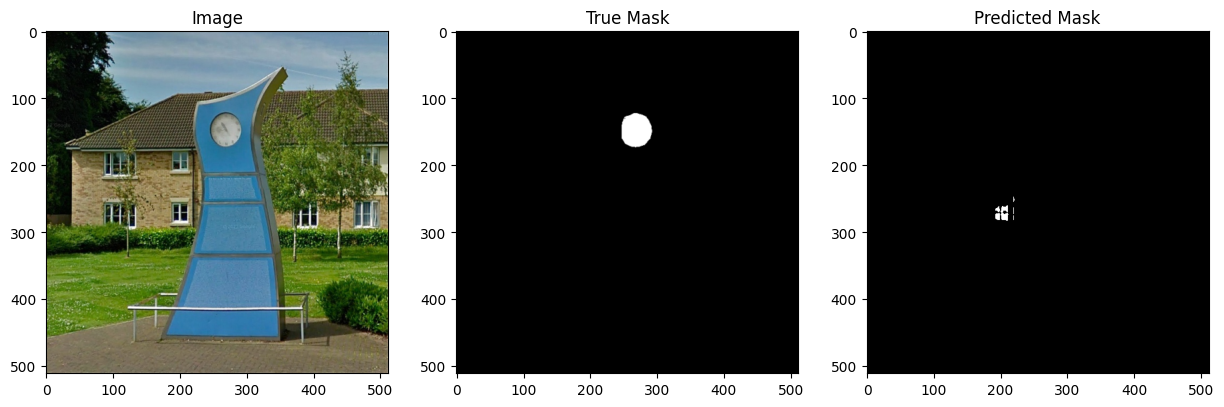

In [ ]:
model.eval()
with torch.no_grad():
    img, true_mask = val_dataset[0]
    img = img.unsqueeze(0).to(device)
    pred_mask = torch.sigmoid(model(img))
    pred_mask = (pred_mask > 0.5).float().cpu()[0,0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img[0].permute(1,2,0).cpu())
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(true_mask[0], cmap="gray")
plt.title("True Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()


In [ ]:
model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


UNet(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
metrics = evaluate_model(model, val_loader, device)

print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)
print(f"Average IoU: {metrics['IoU']:.4f}")
print(f"Average Dice Score: {metrics['Dice']:.4f}")
print(f"Average Accuracy: {metrics['Accuracy']:.4f}")
print(f"Average Area Error Ratio: {metrics['AreaErrorRatio']:.4f}")
print(f"Average ROC AUC: {metrics['ROC_AUC']:.4f}")
print("="*50)
print("Evaluation completed successfully!")



FINAL EVALUATION RESULTS
Average IoU: 0.2089
Average Dice Score: 0.3105
Average Accuracy: 0.7475
Average Area Error Ratio: 186736005.0989
Average ROC AUC: -0.8055
Evaluation completed successfully!


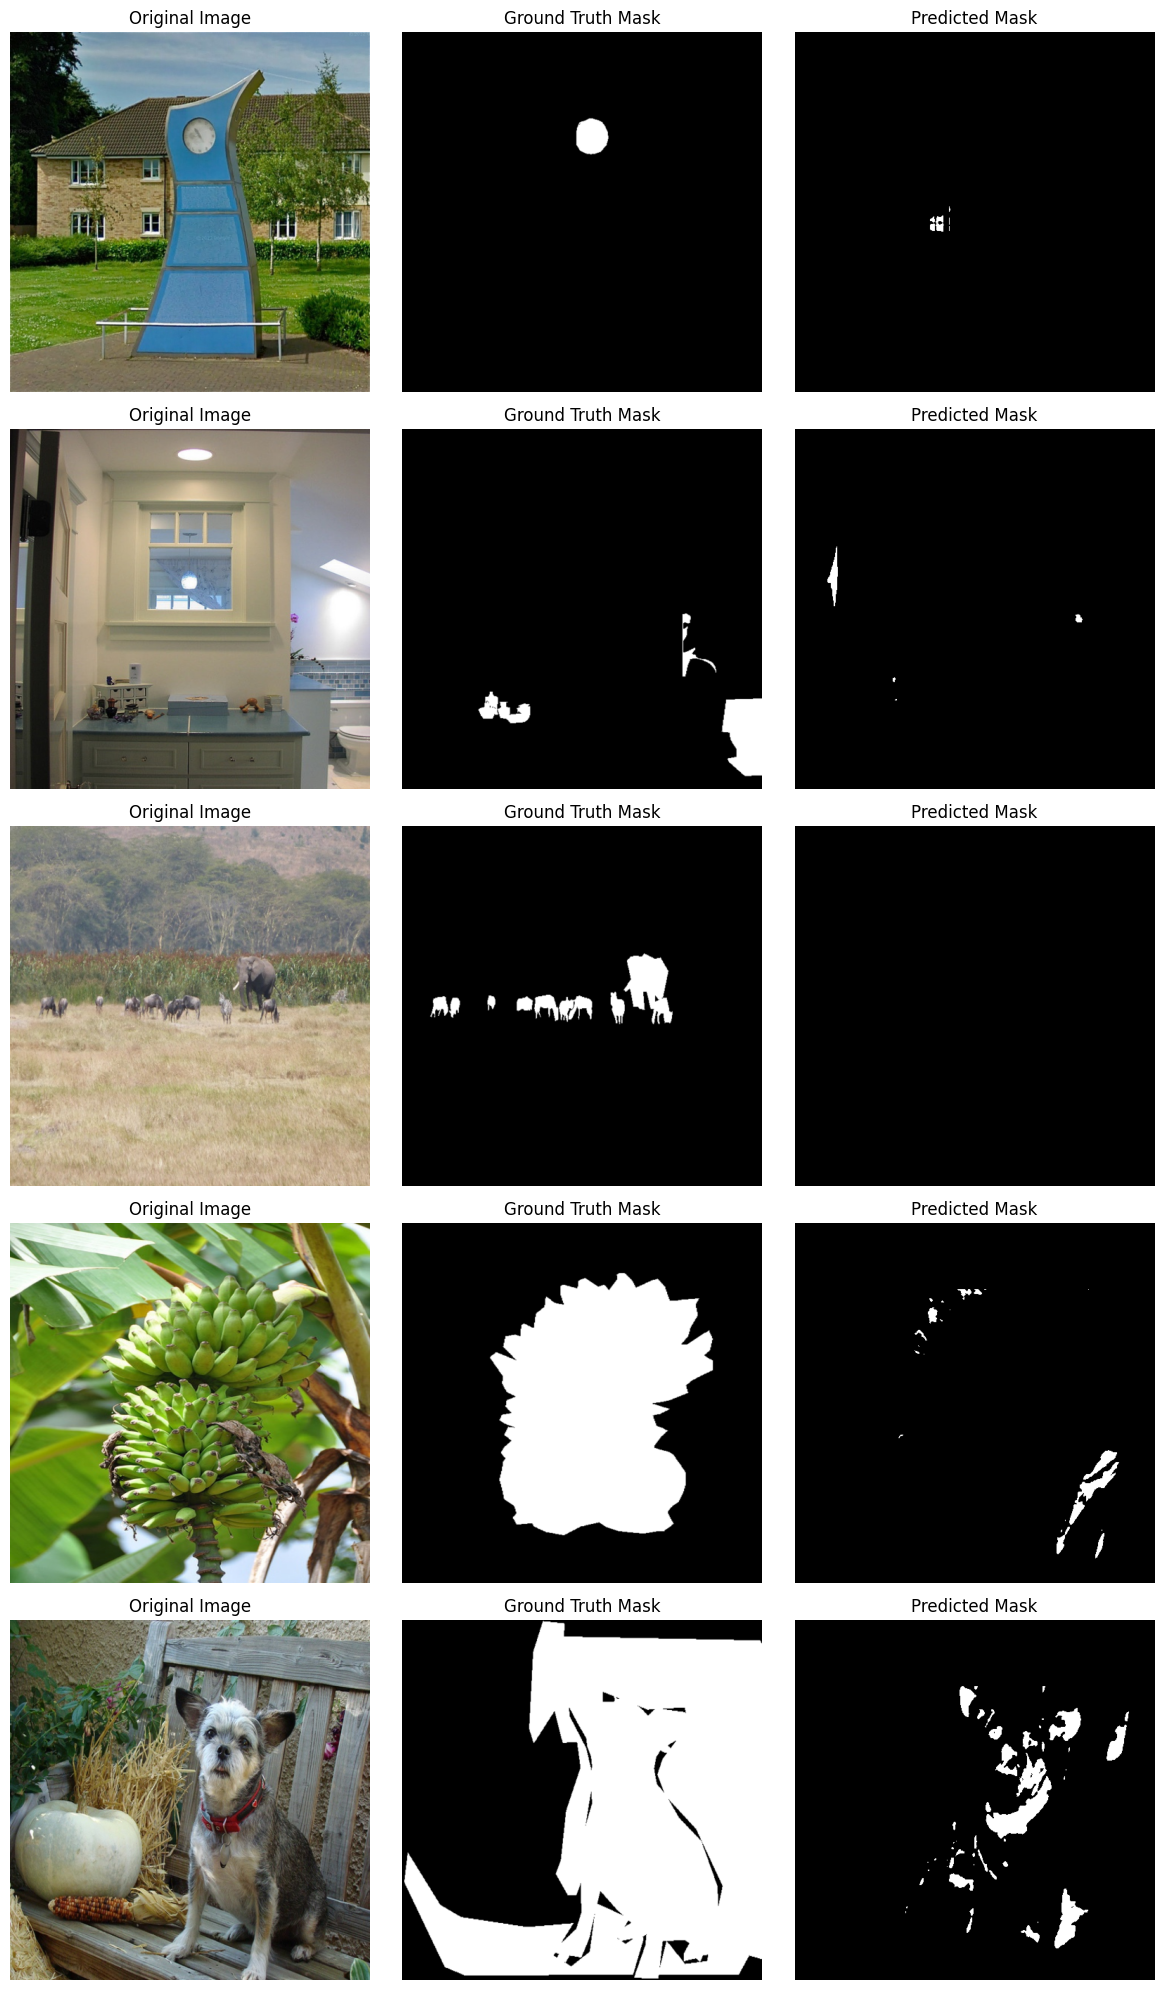

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, device, num_samples=5):
    """
    Visualize original image, ground truth mask, and predicted mask.
    """
    model.eval()
    plt.figure(figsize=(12, num_samples * 4))

    for i in range(num_samples):
        # Load image and mask from dataset
        img, true_mask = dataset[i]
        img = img.unsqueeze(0).to(device)  # add batch dimension

        # Predict mask
        with torch.no_grad():
            pred_mask = torch.sigmoid(model(img))
            pred_mask = (pred_mask > 0.5).float()

        # Convert tensors for visualization
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        pred_mask_np = pred_mask.squeeze().cpu().numpy()

        # Plot original image, ground truth, and prediction
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask_np, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# -------------------------------
# Load model and visualize results
# -------------------------------
model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# Visualize 5 random samples from validation dataset
visualize_predictions(model, val_dataset, device, num_samples=5)
